# phData Data Science Project Challenge


Author: Lee Miller

Date: 2024-01-27




In [290]:
import pandas as pd
import importlib

In [1]:
from challenge.data import df

In [2]:
df.head(10)

,age,b1,b2,c10,c3,c4,c8,dow,employment,i1,...,i5,marriage-status,month,n2,n3,n4,n5,n6,school,successful_sell
0,34,yes,no,no,False,new,NaN,fri,management,-1.8,...,5099.1,divorced,apr,2,530,999,0.001771,0,5 - a decent amount,no
1,28,yes,no,yes,False,new,NaN,thu,assistant,-1.8,...,5099.1,divorced,may,1,750,999,-1.673152,0,5 - a lot,yes
2,55,no,no,no,unknown,new,NaN,tue,leisure,1.4,...,5228.1,married,jul,3,600,999,0.927946,0,2 - a little bit,no
3,47,yes,no,no,False,new,NaN,mon,assistant,-0.1,...,5195.8,married,nov,1,860,999,0.203013,0,5 - a lot,no
4,49,no,no,no,unknown,new,NaN,tue,assistant,1.4,...,5228.1,married,jul,6,620,999,0.990804,0,5 - a lot,no
5,48,no,no,no,False,new,NaN,tue,engineer,-0.1,...,5195.8,married,nov,4,620,999,-0.766658,0,5 - a lot,no
6,30,no,no,no,unknown,new,NaN,fri,customer service,-1.8,...,5099.1,single,may,2,530,999,-0.552628,0,4 - average amount,no
7,32,yes,yes,no,False,new,NaN,thu,management,-2.9,...,5076.2,married,jun,2,900,999,-0.159617,0,4 - average amount,no
8,53,yes,yes,no,False,new,NaN,thu,management,-1.8,...,5008.7,divorced,apr,6,660,999,0.140678,0,5 - a lot,no
9,30,no,no,no,False,old,NaN,mon,laborer,1.1,...,5191.0,married,may,4,650,999,0.570528,0,4 - average amount,no


## Initial impression

We have a mixture of columns with varying data types, and columns such as c8 with `NaN` values as well.
The `successful_sell` column contains our target values as no/yes, which will be predicted using a binary classifier.

Let's start by getting a look at the distribution of the target values.

In [20]:
df.successful_sell.value_counts(dropna=False)

successful_sell
no     36548
yes     4640
Name: count, dtype: int64

### Notes

It's important to note that the class imbalance is significant. The `yes` class is a factor of ~9 lower than the `no` class.
A classifier trained on this data could achieve a high accuracy score by simply predicting the `no` class. We will need to
explore some strategies to mitigate this, and utilize metrics that give us insight into how the `yes` class is being predicted.

Let's examine some of the feature data.

In [34]:
# Checking for NaN values
nan_cols = []
for col in set(df.columns) - {"successful_sell"}:
    if df[col].isna().any():
        counts = df[col].value_counts(dropna=False)
        print(f"NaN values in {col}:\n{counts}\n\n")
        nan_cols.append(col)

NaN values in marriage-status:
marriage-status
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64


NaN values in c8:
c8
NaN    35563
no      4252
yes     1373
Name: count, dtype: int64


NaN values in school:
school
5 - a lot              12168
4 - average amount      9515
3 - a bit more          6045
5 - a decent amount     5243
1 - almost none         4176
2 - a little bit        2292
NaN                     1731
0 - none                  18
Name: count, dtype: int64


NaN values in b2:
b2
no     33950
yes     6248
NaN      990
Name: count, dtype: int64




In [29]:
# data types
df.dtypes

age                  int64
b1                  object
b2                  object
c10                 object
c3                  object
c4                  object
c8                  object
dow                 object
employment          object
i1                 float64
i2                 float64
i3                 float64
i4                 float64
i5                 float64
marriage-status     object
month               object
n2                   int64
n3                   int64
n4                   int64
n5                 float64
n6                   int64
school              object
successful_sell     object
dtype: object

In [33]:
# Checking unique values in categorical columns
for col in set(df.columns) - {"successful_sell"}:
    if df[col].dtype != float and df[col].dtype != int:
        counts = df[col].value_counts(dropna=False)
        print(f"Unique values in {col}:\n{counts}\n\n")

Unique values in c4:
c4
new    26144
old    15044
Name: count, dtype: int64


Unique values in marriage-status:
marriage-status
married     24928
single      11568
divorced     4612
NaN            80
Name: count, dtype: int64


Unique values in c10:
c10
no     36548
yes     4640
Name: count, dtype: int64


Unique values in dow:
dow
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64


Unique values in c3:
c3
False      32588
unknown     8597
True           3
Name: count, dtype: int64


Unique values in b1:
b1
yes    21576
no     18622
-1       990
Name: count, dtype: int64


Unique values in c8:
c8
NaN    35563
no      4252
yes     1373
Name: count, dtype: int64


Unique values in month:
month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64


Unique values in employment:
employment
assistant           10422
laborer              9254
engineer     

In [37]:
# Note that column c10 is redundant with our targets
all(df.c10 == df.successful_sell)

True

In [284]:
from scipy import stats

x = df.c4.factorize()[0]
y = df.successful_sell.factorize()[0]
stats.pointbiserialr(x, y)

SignificanceResult(statistic=-0.14477305571200064, pvalue=9.856509177707399e-192)

In [285]:
tmp = df[df.b1 != -1]
x = tmp.b1.factorize()[0]
y = tmp.successful_sell.factorize()[0]
stats.pointbiserialr(x, y)

SignificanceResult(statistic=-0.011378986858011215, pvalue=0.020924147238175206)

In [286]:
tmp = df[df.c8.notna()]
x = tmp.c8.factorize()[0]
y = tmp.successful_sell.factorize()[0]
stats.pointbiserialr(x, y)

SignificanceResult(statistic=0.4943678440080759, pvalue=0.0)

In [289]:
tmp = df[df.b2.notna()]
x = tmp.b2.factorize()[0]
y = tmp.successful_sell.factorize()[0]
stats.pointbiserialr(x, y)

SignificanceResult(statistic=-0.0046815501226473225, pvalue=0.3479359031440844)

## Discussion

We have a mix of datatypes, with floating point, integer and categorical columns.
Several of the columns are missing values, and we will need to decide how to treat them.
These columns are:
- `marriage-status`: a small fraction of these are NaN
- `c8`: a large fraction are NaN, but good correlation to targets for non-NaN values with 0 p-value (reject null hypothesis, 
- `school`: where `none` is also a value, we need to decide if NaN is an equivalent category
- `b2`: small, but not insignificant number of NaN, almost no correlation to targets

Additionally, we can identify:
- `c3`: contains numerous unknown values and 3 values of True
- `b1`: contains the value of -1, which is effectively NaN, little to no correlation
- `employment`: contains strings for none and unknown, and could mean different things (none/unemployed, unknown/NaN)

Columns `dow` and `month` contain categorical data that may be useful as encoded values that numerically ascend with their logical ordering.

Let's continue to examine the numerical data.

In [45]:
from scipy.stats import zscore

# Checking z scores in numerical columns
numeric_cols = []
for col in set(df.columns) - {"successful_sell"}:
    if df[col].dtype == float or df[col].dtype == int:
        s = abs(zscore(df[col]))
        print(f"Count {col} |Z| > 3: {len(s[s>3])}")
        numeric_cols.append(col)

Count i4 |Z| > 3: 0
Count n3 |Z| > 3: 0
Count n6 |Z| > 3: 1064
Count n2 |Z| > 3: 869
Count n5 |Z| > 3: 107
Count i2 |Z| > 3: 0
Count i3 |Z| > 3: 0
Count i5 |Z| > 3: 0
Count i1 |Z| > 3: 0
Count n4 |Z| > 3: 1515
Count age |Z| > 3: 369


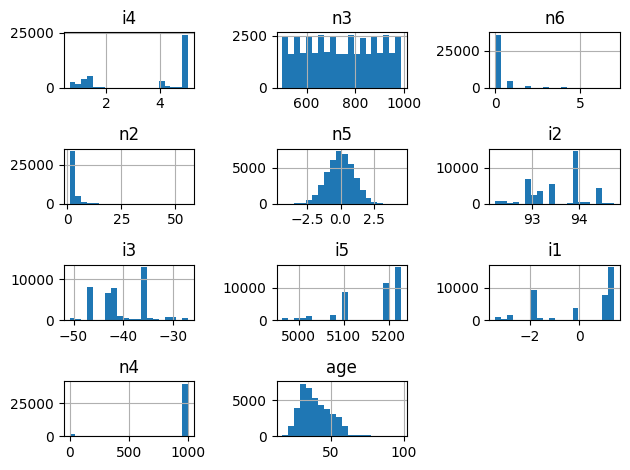

In [206]:
import matplotlib.pyplot as plt

df[numeric_cols].hist(bins=20)
plt.tight_layout()

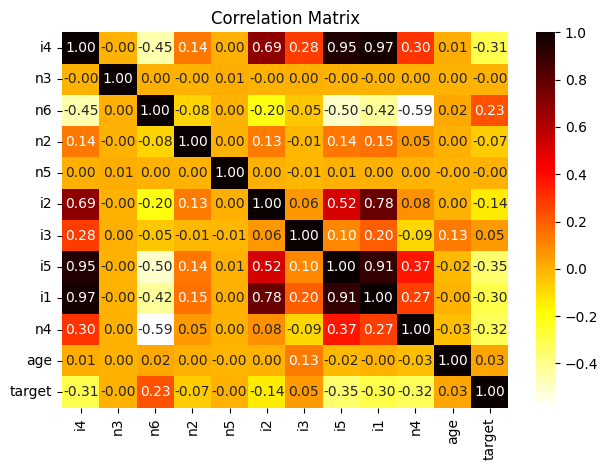

In [75]:
import seaborn as sns

# check covariance
df["target"] = df.successful_sell.factorize()[0]
corr_matrix = df[numeric_cols + ["target"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="hot_r", fmt='.2f')
plt.title("Correlation Matrix")
plt.tight_layout()

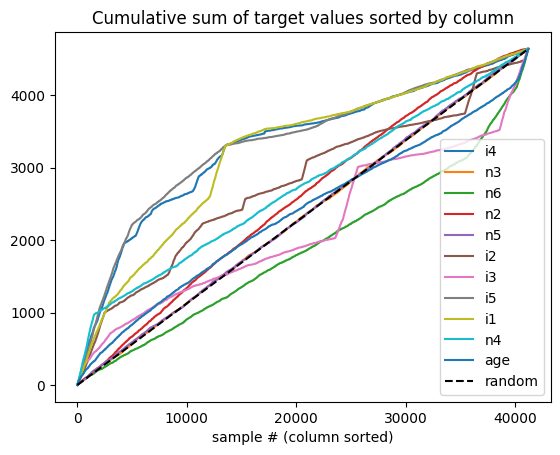

In [235]:
import numpy as np

for col in numeric_cols:
    tmp = df[[col, "target"]].sort_values(by=col)
    t = tmp.target.array

    plt.plot(np.cumsum(t), label=col)

plt.plot([0, len(df)], [0, sum(df.target)], 'k--', label="random")
plt.title("Cumulative sum of target values sorted by column")
plt.xlabel("sample # (column sorted)")
plt.legend()

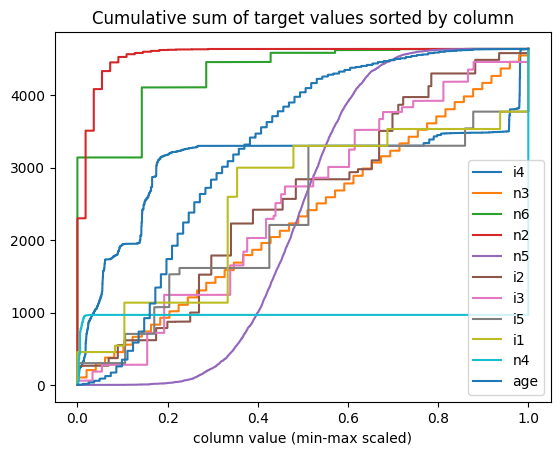

In [241]:
import numpy as np

for col in numeric_cols:
    tmp = df[[col, "target"]].sort_values(by=col)
    t = tmp.target.array
    x = tmp[col]
    x_scaled = (x - x.min())/(x.max() - x.min())

    plt.plot(x_scaled, np.cumsum(t), label=col)

plt.title("Cumulative sum of target values sorted by column")
plt.xlabel("column value (min-max scaled)")
plt.legend()

In [67]:
df.n4.value_counts()[0:5]

n4
999    39673
3        439
6        412
4        118
9         64
Name: count, dtype: int64

In [79]:
df[df.n4 != 999].target.value_counts()

target
1    967
0    548
Name: count, dtype: int64

Middle band (n=1482): -40.8, -37.5
target
0    1089
1     981
Name: count, dtype: int64


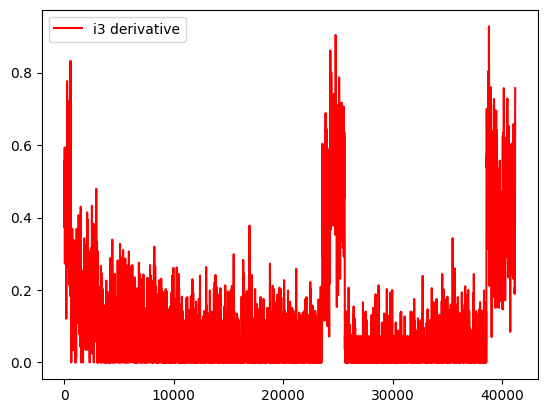

In [273]:
from scipy.signal import savgol_filter

tmp = df[["i3", "target"]].sort_values(by="i3")
t = tmp.target.array
x = tmp.i3.array

window_length, poly_order = 21, 2
cumsum_t = np.cumsum(t)
t_deriv = savgol_filter(cumsum_t, window_length, poly_order, deriv=1)

plt.plot(t_deriv, label='i3 derivative', color='red')
plt.legend()

x_band = x[20000:30000][np.where(t_deriv[20000:30000] > 0.4)[0]]
print(f"Middle band (n={len(x_band)}): {x_band.min()}, {x_band.max()}")
print(df[(df.i3 <= -37.5) & (df.i3 >= -40.8)].target.value_counts())

## Discussion

We can see that several of the columns have numerous values with high z-scores; however, the columns have
several distributions that are mostly not normally distributed.

Otherwise, we can see that `n3` has uniformly distributed values,
`n4` contains "999", which is probably NaN, given its distance from other values. It is still a valuable predictor of the positive class when considering whether or not it equals "999".
`n6` and `n2` are heavily weighted toward small values, where `n6` has 8 discrete values and weakly correlates to the target.

`i1`, `i4` and `i5` have a high covariance and perhaps should be considered along with `i2` (medium covariance) for dimensionality
reduction, as they don't appear to be contributing much variance independently. However, we can also see that `i1` has a few discrete bands where the target values increase rapidly. This offers a potentially important feature not caputured in `i4` or `i5`. Additionally, `i2` has a more complex behvaior with relation to the target variable.

`age` exhibits a roughly flat band in the cumulative sum of target values until the end, where the slope changes quickly. This implies that there's a well defined age group that accounts for some increase response to the target. We can likely threshold this into a categorical predictor, but it could be easily handled by a single node in a tree.

`i3` is uniquely interesting, because while we see no correlation to target, it is clear there are narrow bands with steep responses to the target value. This implies that we could isolate these regions as categorical variables, and there is highly valuable predictive value as well.

`n3`, `n5` exhibit no correlation to the target, and other features. Suspect that these are not useful to the predictor.

# Planning

For the given data, it is reasonable to choose a tree-based method for the following reasons:
- tabular data
- mixture of categorical and continuous features
- good handling of class imbalance
- easier to work with NaN values in categorical features
- apparent banding of target values in continuous features

## Categorical

`c10` is target value data. Exclude from training.

`b1` and `b2` are binary columns likely uncorrelated to the target value. Omit.

`c8` is a promising column, but with significant NaN values. One-hot encode.

`c4` has no NaN values, shows correlation to target. One-hot encode.

`dow` and `month` are cyclical values. Encode each using a sinusoidal encoding.



## Continuous data

`n3`, `n5` can be excluded since they appear to be random uniform and gaussian distributions.

`n2` appears very weakly predictive.

`n4` we will turn into a categorical variable based on whether or not it equals "999"

`n6` and `age` we can leave as-is, since they can be easily accommodated in a decision tree with simple thresholds

`i1`, `i5` and `i4` are highly correlated to each other and somewhat discretized.
`i1` might work well in conjunction with `i5` if we discretize it uniformly across the column value space.
`i4` is unlikely to improve predictive capability, so perhaps we should PCA all 3 columns with `i2`

`i3` has a mid-band that is strongly predictive, yet difficult to capture. Since it's a single band, we can extract it as a separate categorical feature: Middle band (n=1482): -40.8, -37.5, in addition to the continuous data.

In [14]:
cols = ["c8", "c4", "dow", "month", "n2", "n4", "n6", "age", "i1", "i5", "i2", "i3", "successful_sell", "employment", "marriage-status", "school", "i4"]
tmp = df[cols]
tmp[tmp.duplicated()].successful_sell.value_counts()

successful_sell
no     4503
yes     123
Name: count, dtype: int64

In [15]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df[["i4", "i5", "i1", "i2"]])

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)

Explained variance ratio: [9.99808308e-01 1.67651238e-04 1.62609786e-05 7.77989118e-06]
